In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Activation
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
csv_path = 'https://query1.finance.yahoo.com/v7/finance/download/ADA-USD?period1=1516665600&period2=1650672000&interval=1d&events=history&includeAdjustedClose=true'
df = pd.read_csv(csv_path, parse_dates=['Date'])
df = df.sort_values('Date')

In [4]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-23,0.566537,0.592231,0.520013,0.563070,0.563070,375958016
1,2018-01-24,0.563369,0.636009,0.544753,0.622208,0.622208,689838016
2,2018-01-25,0.629337,0.683023,0.621560,0.637495,0.637495,654814016
3,2018-01-26,0.633903,0.652848,0.566218,0.623382,0.623382,810062016
4,2018-01-27,0.623477,0.632956,0.595269,0.616833,0.616833,331308992
...,...,...,...,...,...,...,...
1547,2022-04-19,0.936762,0.954662,0.928201,0.953333,0.953333,777142382
1548,2022-04-20,0.953325,0.974735,0.932510,0.937341,0.937341,828312845
1549,2022-04-21,0.937272,0.969453,0.896912,0.910474,0.910474,871111347
1550,2022-04-22,0.910335,0.923741,0.893973,0.907154,0.907154,725788912


In [5]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

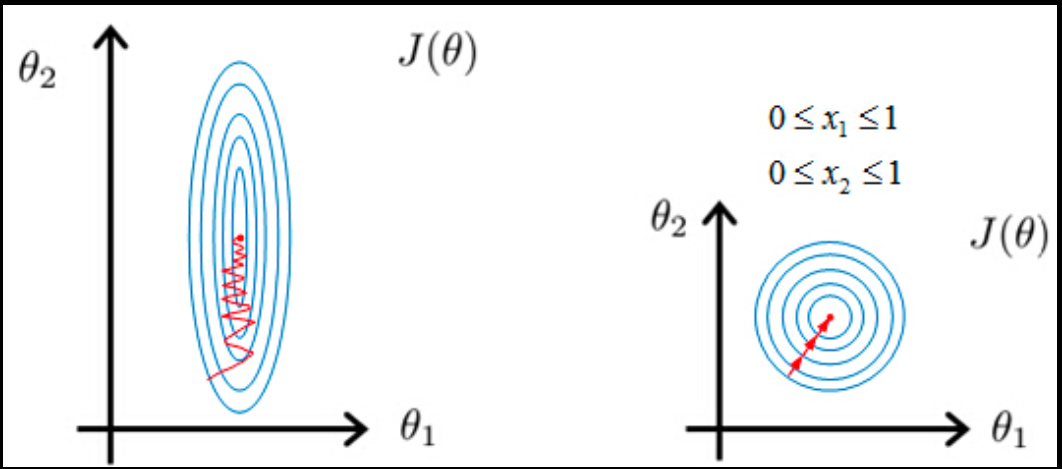

In [6]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

In [7]:
SEQ_LEN = 100

def dataset_generator_lstm(dataset, look_back=5):
    X_data, y_data = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        X_data.append(window_size_x)
        y_data.append(dataset[i + look_back, 0])
    return np.array(X_data), np.array(y_data)

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [8]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
  input_shape=(WINDOW_SIZE, X_train.shape[-1])
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=True)
))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(
  CuDNNLSTM(WINDOW_SIZE, return_sequences=False)
))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 99, 198)          80784     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 198)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 99, 396)          630432    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 99, 396)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 99, 198)          393624    
 nal)                                                            
                                                        

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

BATCH_SIZE = 64

checkpoint_path = 'ADA_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]
model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=False,
    validation_split=0.1,
    callbacks=callbacks
)

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.0210
Epoch 00001: val_loss improved from inf to 0.37357, saving model to ADA_model.hdf5
20/20 [==============================] - 8s 120ms/step - loss: 0.0210 - val_loss: 0.3736
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.0457
Epoch 00002: val_loss improved from 0.37357 to 0.00577, saving model to ADA_model.hdf5
20/20 [==============================] - 1s 70ms/step - loss: 0.0499 - val_loss: 0.0058
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 0.0754
Epoch 00003: val_loss did not improve from 0.00577
20/20 [==============================] - 1s 66ms/step - loss: 0.0878 - val_loss: 0.1741
Epoch 4/100
19/20 [===========================>..] - ETA: 0s - loss: 0.0064 
Epoch 00004: val_loss did not improve from 0.00577
20/20 [==============================] - 1s 65ms/step - loss: 0.0068 - val_loss: 0.0843
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 0

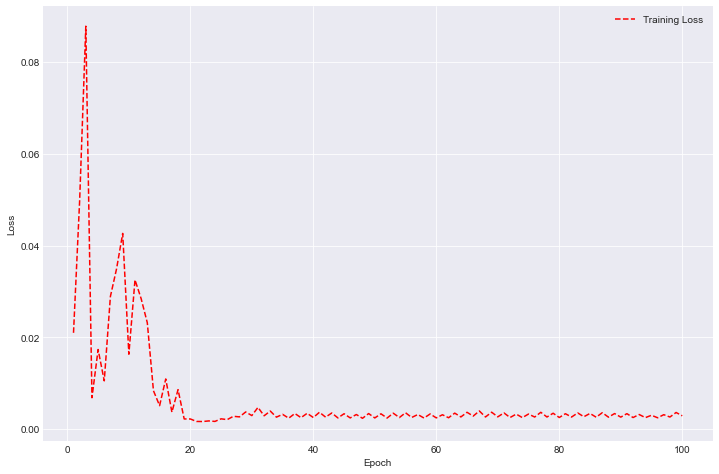

In [11]:
loss = history.history['loss']
epoch_count = range(1, len(loss) + 1)
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

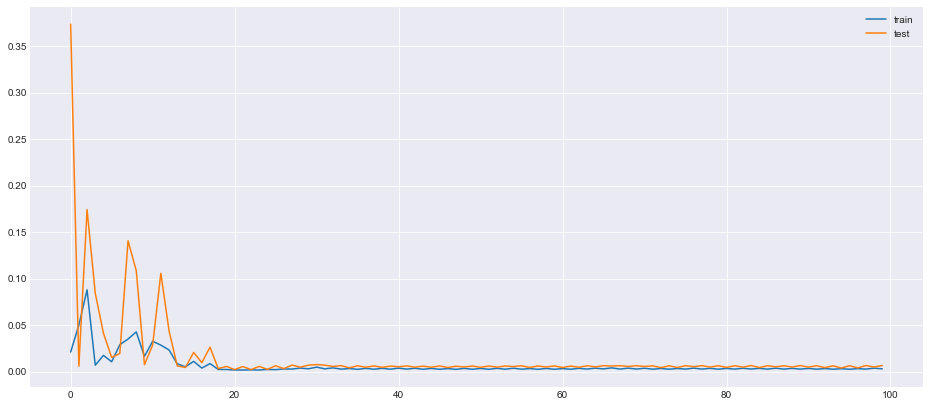

In [12]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
from tensorflow.keras.models import load_model

checkpoint_path = 'ADA_model.hdf5'

model_from_saved_checkpoint = load_model(checkpoint_path)

In [14]:
y_pred = model_from_saved_checkpoint.predict(X_test)

In [15]:
y_pred_transformed = scaler.inverse_transform(y_pred)
y_test_transformed = scaler.inverse_transform(y_test)

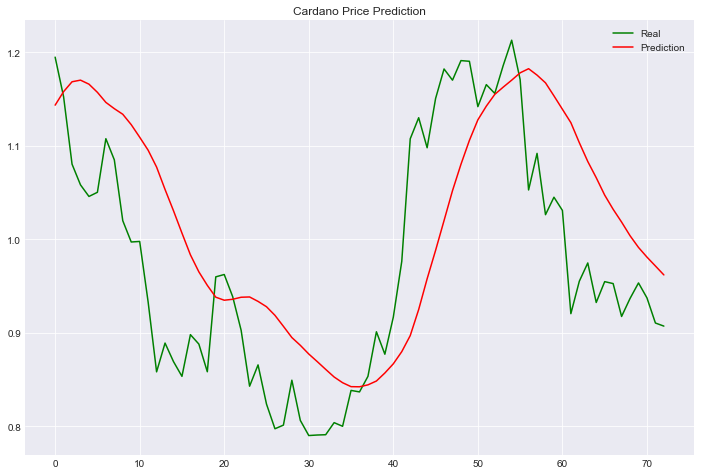

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_transformed, color='green', label='Real')
plt.plot(y_pred_transformed, color='red', label='Prediction')
plt.title('Cardano Price Prediction')
plt.legend()
plt.show()

In [17]:
mean_absolute_error(y_pred_transformed, y_test_transformed)

0.08668856777149357

In [8]:
#  Реализация предсказаний на несколько дней через стек
from tensorflow.keras.models import load_model

checkpoint_path = 'ADA_model.hdf5'

model = load_model(checkpoint_path)

features = X_test[-1]
pred_len = 10
pred_list = []
for _ in range(pred_len):
    pred = model.predict(features)
    pred_list.append(pred)
    np.delete(features, 0)
    np.append(features, pred)

    
pred_list

[array([[0.18940803],
        [0.18969135],
        [0.18971755],
        [0.19026266],
        [0.19118263],
        [0.19054933],
        [0.18994088],
        [0.18953009],
        [0.1888696 ],
        [0.18859315],
        [0.18886538],
        [0.18859257],
        [0.18848002],
        [0.18865342],
        [0.18847983],
        [0.1885144 ],
        [0.1885582 ],
        [0.18845019],
        [0.18852268],
        [0.18870027],
        [0.18840833],
        [0.18854292],
        [0.18893024],
        [0.18888973],
        [0.18897392],
        [0.1892323 ],
        [0.18914126],
        [0.18922009],
        [0.18901275],
        [0.1886598 ],
        [0.1885515 ],
        [0.188491  ],
        [0.18851273],
        [0.18879303],
        [0.18868245],
        [0.18836431],
        [0.18825303],
        [0.18825592],
        [0.18793963],
        [0.18757562],
        [0.18772562],
        [0.18762888],
        [0.18755217],
        [0.18776955],
        [0.18772025],
        [0

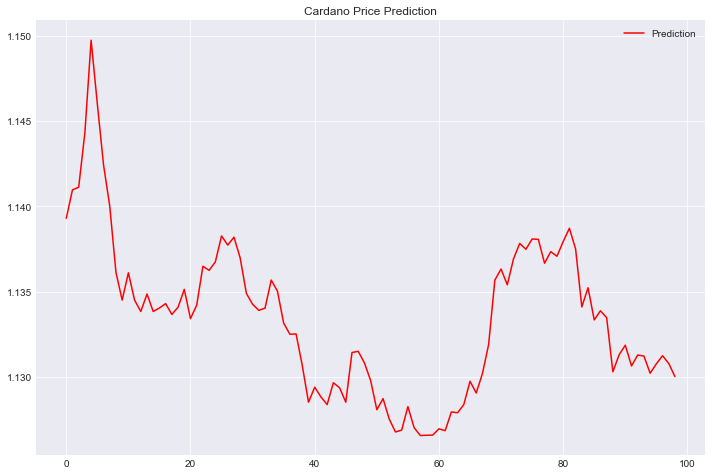

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(scaler.inverse_transform(pred_list[0] * 2), color='red', label='Prediction')
plt.title('Cardano Price Prediction')
plt.legend()
plt.show()